In [ ]:
import os
import random
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.datasets import CocoDetection
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/drive')#drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
#drive.mount('/drive')#drive.mount('/content/drive')
dataset_path = '/drive/MyDrive/Fish_Dataset'#DATA_DIR = '/content/drive/MyDrive/Food/'

In [ ]:
class FishSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        """
        Args:
            root_dir (string): Корневая директория с поддиректориями fish_name и fish_name TG.
            transform (callable, optional): Трансформация для изображений.
            mask_transform (callable, optional): Трансформация для масок.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.mask_transform = mask_transform

        self.image_paths = []
        self.mask_paths = []

        # Получение списка всех поддиректорий
        all_subdirs = os.listdir(root_dir)

        # Разделение на папки с изображениями и масками
        image_dirs = [d for d in all_subdirs if not d.endswith("GT")]
        mask_dirs = [d for d in all_subdirs if d.endswith("GT")]

        for img_dir in image_dirs:
            mask_dir = f"{img_dir} GT"
            if mask_dir not in mask_dirs:
                print(f"Предупреждение: Папка масок для {img_dir} не найдена.")
                continue

            img_folder = os.path.join(root_dir, img_dir)
            mask_folder = os.path.join(root_dir, mask_dir)

            img_files = sorted(os.listdir(img_folder))
            mask_files = sorted(os.listdir(mask_folder))

            # Предполагается, что названия файлов совпадают между изображениями и масками
            for img_file in img_files:
                img_path = os.path.join(img_folder, img_file)
                mask_file = img_file  # Предполагается, что маска имеет такое же имя
                mask_path = os.path.join(mask_folder, mask_file)

                if not os.path.exists(mask_path):
                    print(f"Предупреждение: Маска не найдена для {img_path}")
                    continue

                self.image_paths.append(img_path)
                self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            # Преобразование маски в тип LongTensor
            mask = torch.as_tensor(np.array(mask), dtype=torch.long)

        return image, mask

In [ ]:
os.listdir(dataset_path)

['Trout', 'Trout GT']

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
mask_transform = transforms.Compose([
    transforms.Resize((224, 224))
    ,
    transforms.ToTensor()
])


dataset = FishSegmentationDataset(
    root_dir=dataset_path,
    transform=transform,
    mask_transform=mask_transform
)


train_size = int(0.7 * len(dataset))
val_test_size = len(dataset) - train_size
train_dataset, val_test_dataset = random_split(dataset, [train_size, val_test_size])

val_size = int(0.6 * len(val_test_dataset))
test_size = len(val_test_dataset) - val_size
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])




print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 700
Validation dataset size: 180
Test dataset size: 120


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

Shape of mask 0: (224, 224)


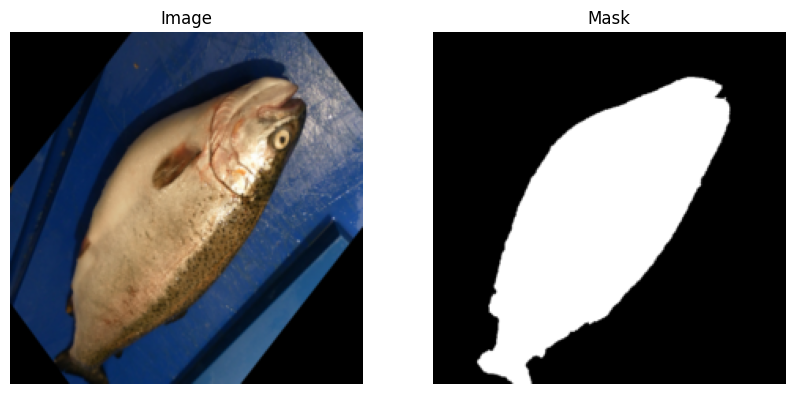

Shape of mask 1: (224, 224)


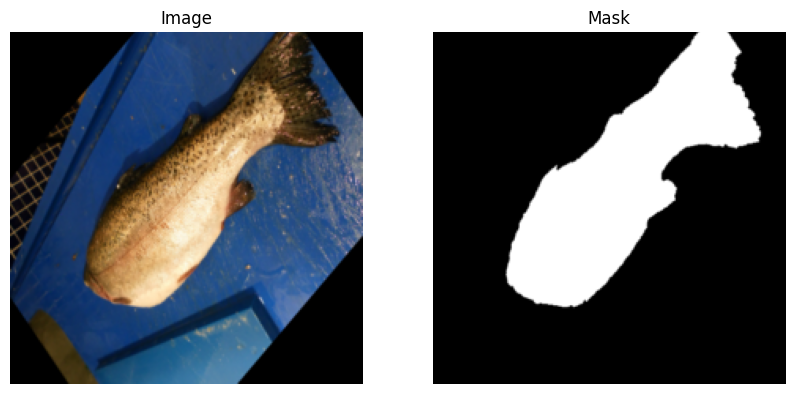

Shape of mask 2: (224, 224)


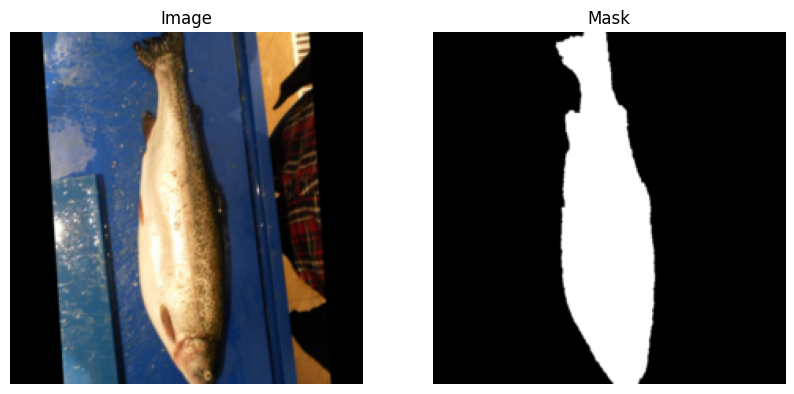

Shape of mask 3: (224, 224)


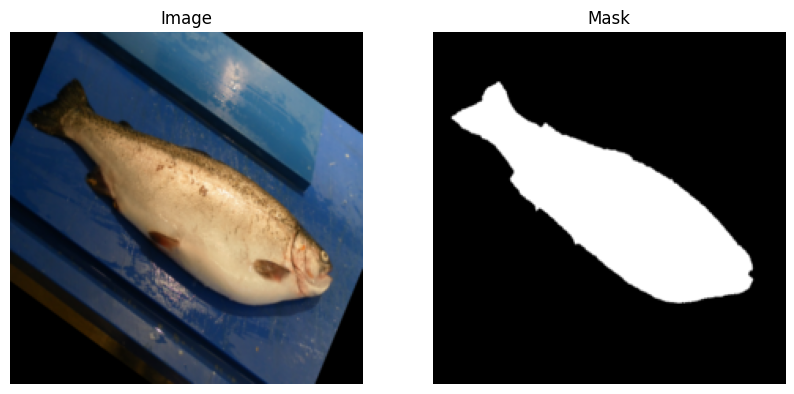

In [ ]:
import matplotlib.pyplot as plt

images, masks = next(iter(train_loader))


images = images.cpu()
masks = masks.cpu()

# Визуализация
batch_size = images.size(0)
for i in range(min(batch_size, 4)):
    # Обработка изображения
    img = images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    # Обработка маски
    mask = masks[i].squeeze().numpy()  # Удаление лишнего канала

    # Проверка формы маски (для отладки, можно удалить позже)
    print(f"Shape of mask {i}: {mask.shape}")  # Должно быть (224, 224)

    # Создание фигуры для отображения
    plt.figure(figsize=(10, 5))

    # Отображение изображения
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis('off')

    # Отображение маски
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')  # Теперь с правильной формой
    plt.title("Mask")
    plt.axis('off')

    plt.show()
    plt.close()  # Закрытие фигуры после отображения

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        def upsample_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # Encoder
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)


        self.bottleneck = conv_block(512, 1024)


        self.upconv4 = upsample_block(1024, 512)
        self.dec4 = conv_block(1024, 512)

        self.upconv3 = upsample_block(512, 256)
        self.dec3 = conv_block(512, 256)

        self.upconv2 = upsample_block(256, 128)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = upsample_block(128, 64)
        self.dec1 = conv_block(128, 64)


        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):

        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))


        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))


        dec4 = self.dec4(torch.cat((self.upconv4(bottleneck), enc4), dim=1))
        dec3 = self.dec3(torch.cat((self.upconv3(dec4), enc3), dim=1))
        dec2 = self.dec2(torch.cat((self.upconv2(dec3), enc2), dim=1))
        dec1 = self.dec1(torch.cat((self.upconv1(dec2), enc1), dim=1))

        return self.out_conv(dec1)


In [ ]:

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0


    for batch in train_loader:

        if len(batch) == 2:
            batch_inputs, batch_labels = batch
        else:
            batch_inputs, batch_labels = batch[:2]

        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        optimizer.zero_grad()


        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)


        loss.backward()
        optimizer.step()


        total_loss += loss.item()



    average_loss = total_loss / len(train_loader)

    return average_loss


def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0


    with torch.no_grad():
        for batch in val_loader:
            if len(batch) == 2:
                batch_inputs, batch_labels = batch
            else:
                batch_inputs, batch_labels = batch[:2]

            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)


            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)


            total_loss += loss.item()



    average_loss = total_loss / len(val_loader)

    return average_loss

In [ ]:

unet_model = UNet().to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.AdamW(unet_model.parameters(), lr=1e-3)


num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train(unet_model, train_loader, criterion, optimizer, device)
    val_loss = validate(unet_model, val_loader, criterion, device)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f} '
          f'Validation Loss: {val_loss:.4f}')

print('Training was completed')

Epoch [1/5], Train Loss: 0.1769 Validation Loss: 0.2344
Epoch [2/5], Train Loss: 0.0673 Validation Loss: 0.0522
Epoch [3/5], Train Loss: 0.0436 Validation Loss: 0.0393
Epoch [4/5], Train Loss: 0.0326 Validation Loss: 0.0351
Epoch [5/5], Train Loss: 0.0315 Validation Loss: 0.0493
Training was completed


In [ ]:
def predict_and_display(model, test_loader, device, num_images=10):
    model.eval()
    images, masks, preds = [], [], []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if len(batch) == 2:
                batch_inputs, batch_labels = batch
            else:
                batch_inputs, batch_labels = batch[:2]

            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            outputs = model(batch_inputs)
            preds.append(torch.sigmoid(outputs).cpu())
            images.append(batch_inputs.cpu())
            masks.append(batch_labels.cpu())

            if i >= num_images - 1:
                break


    return images, masks, preds


test_images, test_masks, test_preds = predict_and_display(unet_model, test_loader, device, num_images=10)

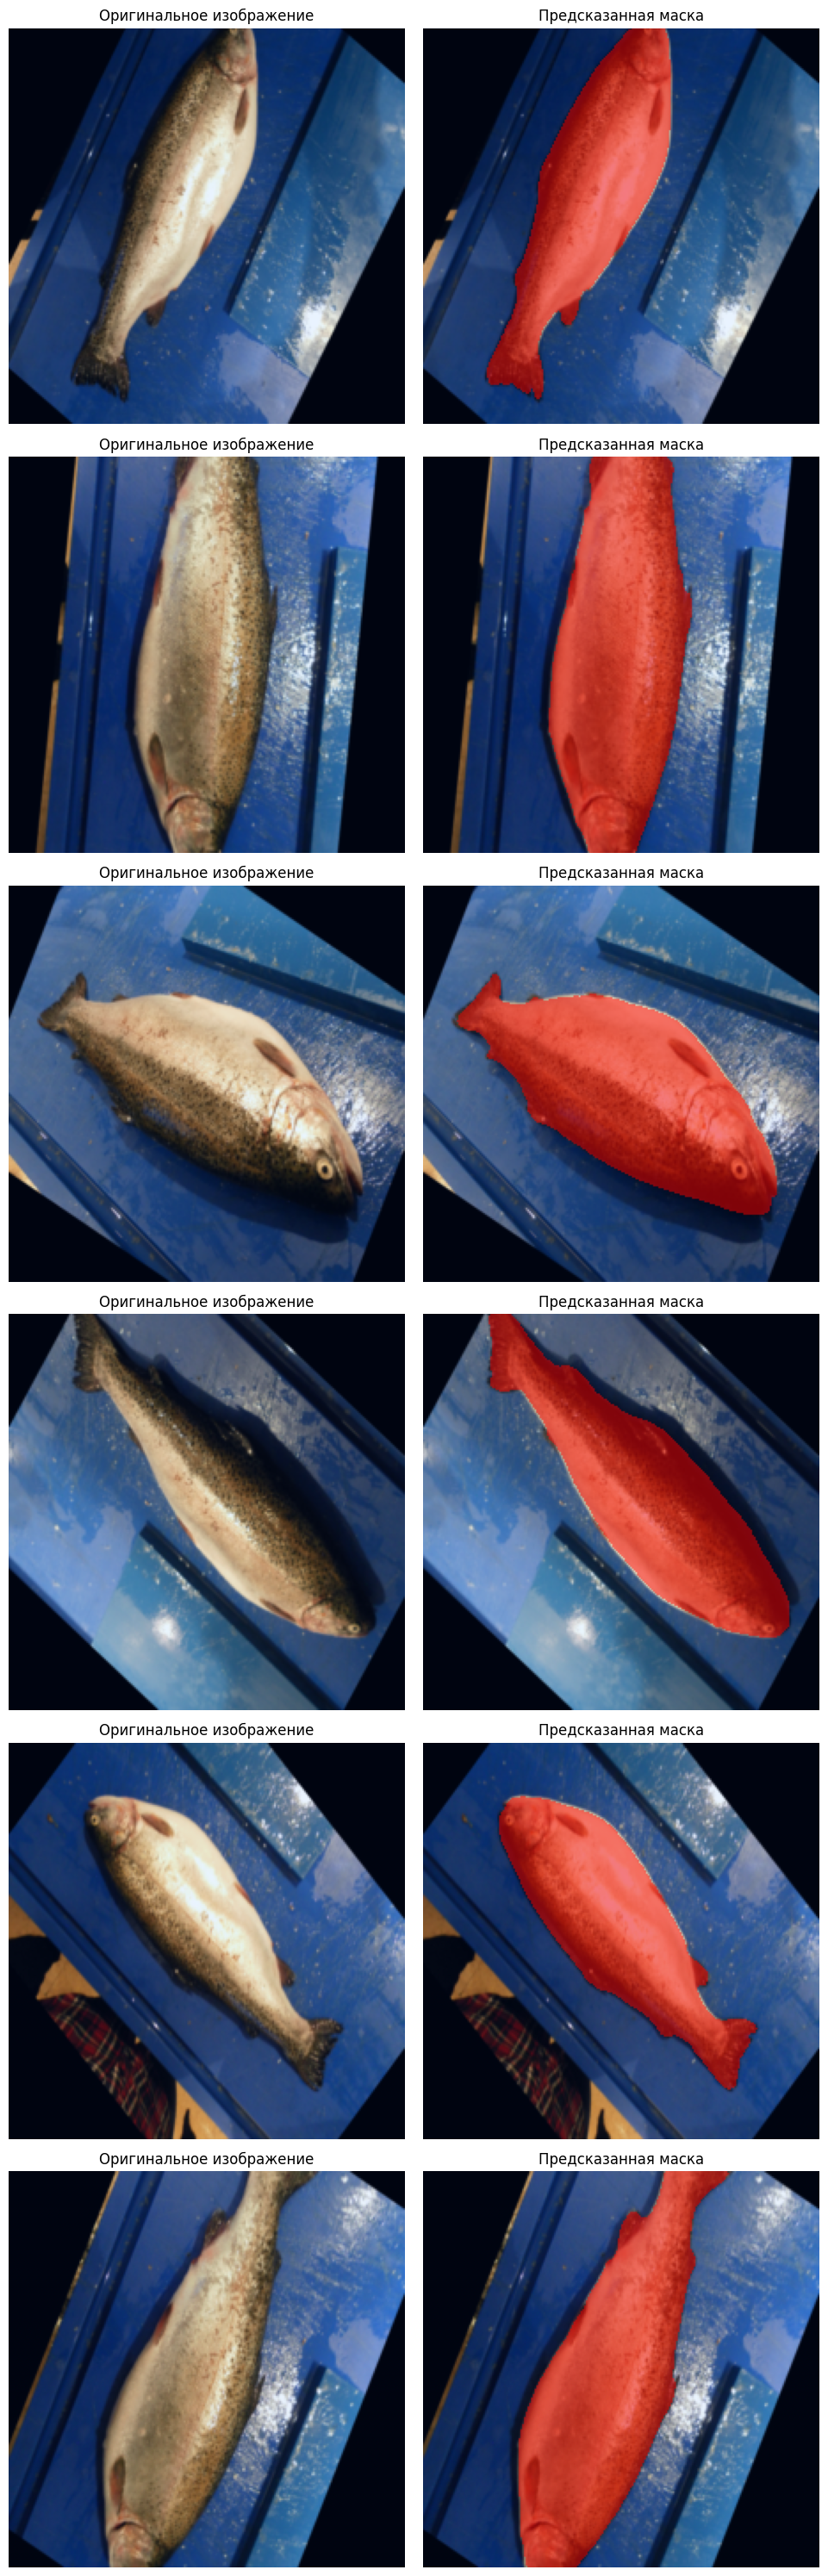

In [ ]:
def visualize_predictions_with_overlay(images, masks, preds,num_images=10):
    fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 5))

    for i in range(num_images):
        # Выбираем первый пример из батча
        img = images[i][0].permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        mask = masks[i][0].squeeze().numpy()         # (1, H, W) -> (H, W)
        pred = (preds[i][0].squeeze().numpy() > 0.5) # (1, H, W) -> (H, W),  бинаризация с порогом 0.5

        # Нормализация изображения
        img = (img - img.min()) / (img.max() - img.min())


        overlay = img.copy()
        overlay[pred == 1] = [1, 0, 0]  # Красный цвет для сегментированной области
        alpha = 0.5
        img_with_overlay = img * (1 - alpha) + overlay * alpha
        #######
        # Наложение маски на изображение
        #img_with_overlay[pred == 1] = red_mask[pred == 1]

        # Отображение оригинального изображения
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Оригинальное изображение')
        axs[i, 0].axis('off')

        # Отображение изображения с наложенной предсказанной маской
        axs[i, 1].imshow(img_with_overlay)
        axs[i, 1].set_title(f'Предсказанная маска')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


visualize_predictions_with_overlay(test_images, test_masks, test_preds, num_images=6)

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 18.7 MB/s eta 0:00:00


In [ ]:
from torchmetrics import JaccardIndex
target = torch.randint(0, 2, (10, 25, 25))
pred = torch.tensor(target)
pred[2:5, 7:13, 9:15] = 1 - pred[2:5, 7:13, 9:15]
jaccard = JaccardIndex(task='multiclass', num_classes=2)
jaccard(pred, target)

tensor(0.9660)